In [40]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import xgboost as xgb

In [41]:
# Load Adult Income dataset from OpenML
data = fetch_openml(name='adult', version=2, as_frame=True)

X = data.data
y = data.target

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Dataset shape: (48842, 14)
Target distribution:
 class
<=50K    37155
>50K     11687
Name: count, dtype: int64


In [59]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


categorical_cols = X.select_dtypes(include=['category', 'object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X_imputed[col] = le.fit_transform(X_imputed[col])


le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_test_original = X.iloc[X_test.index]

In [66]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

print("XGBoost model trained successfully.")

XGBoost model trained successfully.


Accuracy: 0.8769
Precision: 0.7681
Recall: 0.6799
F1 Score: 0.7213


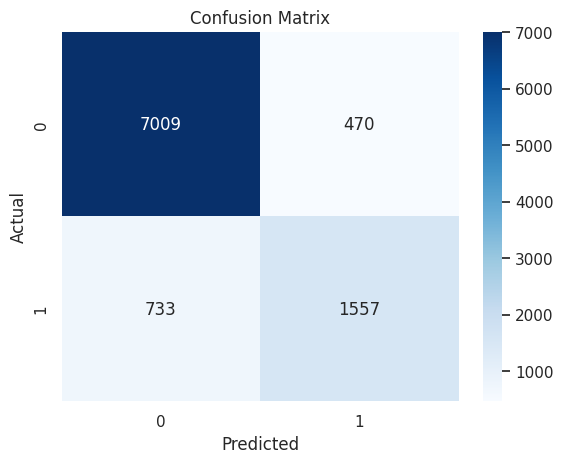

In [67]:
# Predictions
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

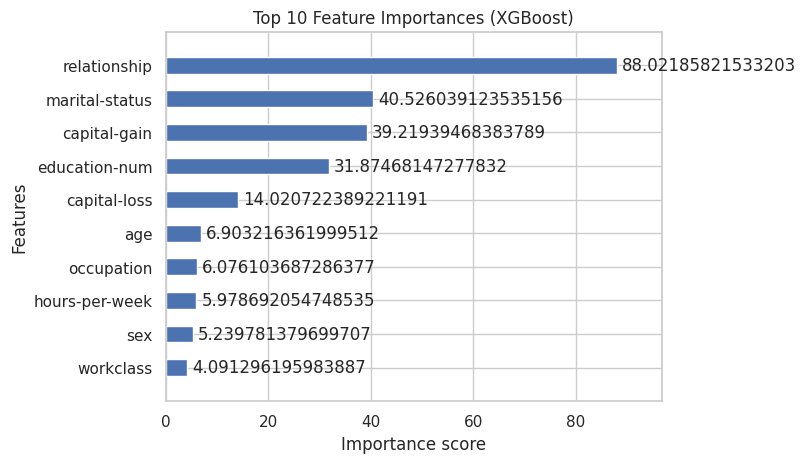

In [68]:
# Feature importance plot
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

In [69]:
# Example Test Case
test_cases = pd.DataFrame({
    "age": [25, 40, 50, 35],
    "workclass": ["Private", "Self-emp-not-inc", "Federal-gov", "Private"],
    "fnlwgt": [226802, 123011, 300000, 180000],
    "education": ["11th", "Bachelors", "Doctorate", "Masters"],
    "education-num": [7, 13, 16, 14],
    "marital-status": ["Never-married", "Married-civ-spouse", "Married-civ-spouse", "Divorced"],
    "occupation": ["Machine-op-inspct", "Exec-managerial", "Prof-specialty", "Sales"],
    "relationship": ["Own-child", "Husband", "Husband", "Not-in-family"],
    "race": ["White", "White", "Asian-Pac-Islander", "Black"],
    "sex": ["Male", "Male", "Male", "Female"],
    "capital-gain": [0, 0, 5000, 0],
    "capital-loss": [0, 0, 0, 0],
    "hours-per-week": [40, 50, 60, 20],
    "native-country": ["United-States", "United-States", "United-States", "Mexico"]
})

# Preprocess
test_cases_imputed = pd.DataFrame(imputer.transform(test_cases), columns=test_cases.columns)
for col in categorical_cols:
    le = LabelEncoder()
    test_cases_imputed[col] = le.fit_transform(test_cases_imputed[col])
test_cases_scaled = scaler.transform(test_cases_imputed)

# Predictions
predictions = best_xgb_model.predict(test_cases_scaled)
predicted_labels = le_target.inverse_transform(predictions)

test_cases["Prediction"] = predicted_labels

print(test_cases)

   age         workclass  fnlwgt  education  education-num  \
0   25           Private  226802       11th              7   
1   40  Self-emp-not-inc  123011  Bachelors             13   
2   50       Federal-gov  300000  Doctorate             16   
3   35           Private  180000    Masters             14   

       marital-status         occupation   relationship                race  \
0       Never-married  Machine-op-inspct      Own-child               White   
1  Married-civ-spouse    Exec-managerial        Husband               White   
2  Married-civ-spouse     Prof-specialty        Husband  Asian-Pac-Islander   
3            Divorced              Sales  Not-in-family               Black   

      sex  capital-gain  capital-loss  hours-per-week native-country  \
0    Male             0             0              40  United-States   
1    Male             0             0              50  United-States   
2    Male          5000             0              60  United-States   
3  Fe

In [70]:
# Example cases from dataset
example_cases = X_test[:5]
example_cases_original = X_test_original.iloc[:5]

predictions = best_xgb_model.predict(example_cases)

accuracy_examples = accuracy_score(y_test[:5], predictions)
print(f"Accuracy for selected dataset cases: {accuracy_examples:.2f} ({accuracy_examples*100:.1f}%)")

results_df = example_cases_original.copy()
results_df["True Label"] = le_target.inverse_transform(y_test[:5])
results_df["Prediction"] = le_target.inverse_transform(predictions)

print("\nExample Case Predictions:")
print(results_df)



Accuracy for selected dataset cases: 0.80 (80.0%)

Example Case Predictions:
       age workclass  fnlwgt  education  education-num      marital-status  \
7762    56   Private   33115    HS-grad              9            Divorced   
23881   25   Private  112847    HS-grad              9  Married-civ-spouse   
30507   43   Private  170525  Bachelors             13            Divorced   
28911   32   Private  186788    HS-grad              9  Married-civ-spouse   
19484   39   Private  277886  Bachelors             13  Married-civ-spouse   

             occupation   relationship   race     sex  capital-gain  \
7762      Other-service      Unmarried  White  Female             0   
23881  Transport-moving      Own-child  Other    Male             0   
30507    Prof-specialty  Not-in-family  White  Female         14344   
28911  Transport-moving        Husband  White    Male             0   
19484             Sales           Wife  White  Female             0   

       capital-loss  hours-